In [10]:
TRAIN_FILE = './data/train.csv'
TEST_FILE = './data/test.csv'
GENDER_FILE= './data/gender_submission.csv'

PASSENGER_ID='PassengerId'
SURVIVED='Survived'
PCLASS='Pclass'
NAME='Name'
SEX='Sex'
AGE='Age'
SIB_SP='SibSp'
PARCH='Parch'
TICKET='Ticket'
FARE='Fare'
CABIN='Cabin'
EMBARKED='Embarked'


COMMON_VALUE = 'S'
GENDERS = {'male': 0, 'female': 1}
ZERO_FARE=0
PORTS = {"S": 0, "C": 1, "Q": 2}

In [11]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def map_age_with_normalization(dataset:pd.DataFrame):
    mean = dataset[AGE].mean()
    std = dataset[AGE].std()
    list_isna = dataset[AGE].isna()

    for line in range(list_isna.shape[0]):
        if (list_isna[line] == True):
            rand_age = np.random.randint(mean - std, mean + std, 1)
            dataset.at[line,AGE] = rand_age


In [13]:
def extract_raw_data():
    data_train = pd.read_csv(TRAIN_FILE)
    data_test = pd.read_csv(TEST_FILE)
    data_result = pd.read_csv(GENDER_FILE)

    data_test = data_test.merge(data_result, on=PASSENGER_ID)

    return pd.concat([data_train, data_test], ignore_index=True)

def set_common_embarked(dataset:pd.DataFrame):
    dataset[EMBARKED] = dataset[EMBARKED].fillna(COMMON_VALUE)


def set_common_fare(dataset:pd.DataFrame):
    dataset[FARE] = dataset[FARE].fillna(ZERO_FARE)
    dataset[FARE] = dataset[FARE].astype(int)
    
def map_gender(dataset:pd.DataFrame):
    dataset[SEX] = dataset[SEX].map(GENDERS)
    'Grouped Bar Chart Example'
def map_ports(dataset:pd.DataFrame):
    dataset[EMBARKED] = dataset[EMBARKED].map(PORTS)

def set_age_as_int(dataset:pd.DataFrame):
    dataset[AGE] = dataset[AGE].astype(int)

raw_data = extract_raw_data()

set_common_embarked(raw_data)
set_common_fare(raw_data)
map_gender(raw_data)
map_ports(raw_data)

map_age_with_normalization(raw_data)
set_age_as_int(raw_data)

    
full_data = raw_data

In [14]:
full_data = full_data.drop(axis=1, columns=[PASSENGER_ID, NAME, TICKET, CABIN, FARE])

five_kfold = KFold(n_splits=5, random_state=0, shuffle=True)

tree_results = []
lasso_results = []

for _, (train_index, test_index) in enumerate(five_kfold.split(full_data)):
    decision_tree = DecisionTreeRegressor(random_state=0)
    lasso_model = linear_model.Lasso(alpha=0.1)
    
    Y_train = full_data.values[train_index][:,3]
    X_train = full_data.values[train_index]
    X_train = np.delete(X_train, 3, 1)

    Y_test = full_data.values[test_index][:,3]
    X_test = full_data.values[test_index]
    X_test = np.delete(X_test, 3, 1)
    
    lasso_model.fit(X_train, Y_train)
    decision_tree.fit(X_train, Y_train)
    
    lasso_y_received = lasso_model.predict(X_test)

    lasso_mse = mean_squared_error(Y_test, lasso_y_received)
    lasso_mae = mean_absolute_error(Y_test, lasso_y_received)
    lasso_mape = mean_absolute_percentage_error(Y_test, lasso_y_received)
    
    lasso_results.append((lasso_mse, lasso_mae, lasso_mape))
    
    tree_y_received = decision_tree.predict(X_test)

    tree_mse = mean_squared_error(Y_test, tree_y_received)
    tree_mae = mean_absolute_error(Y_test, tree_y_received)
    tree_mape = mean_absolute_percentage_error(Y_test, tree_y_received)
    
    tree_results.append((tree_mse, tree_mae, tree_mape))

In [15]:
# Sample data
def plot_chart(index, label, title):
        categories = ['K-1', 'K-2', 'K-3', 'K-4', 'K-5']
        lasso_values = list(map(lambda x: x[index] ,lasso_results))
        tree_values = list(map(lambda x: x[index] ,tree_results))

        # Combine data into a DataFrame
        chart_data = {label: categories * 2,
                'Values': lasso_values + tree_values ,
                'Models': ['Lasso'] * len(categories) + ['Tree'] * len(categories)}

        # Convert to DataFrame
        df = pd.DataFrame(chart_data)

        # Create grouped bar plot using Seaborn
        sns.barplot(x=label, y='Values', hue='Models', data=df)

        # Adding labels and title
        plt.xlabel('KFold')
        plt.ylabel('Values')
        plt.title(title)

        # Show plot
        plt.show()

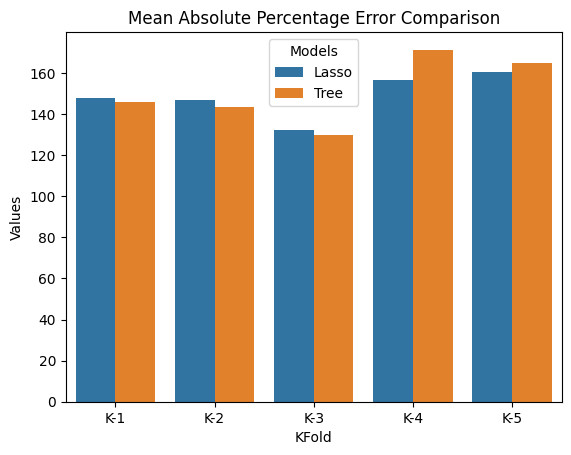

In [16]:
plot_chart(0, "Mean Absolute Percentage Error", "Mean Absolute Percentage Error Comparison")

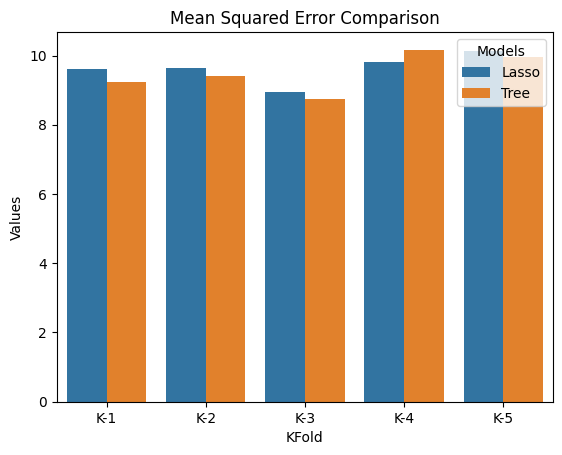

In [17]:
plot_chart(1, "Mean Squared Error", "Mean Squared Error Comparison")

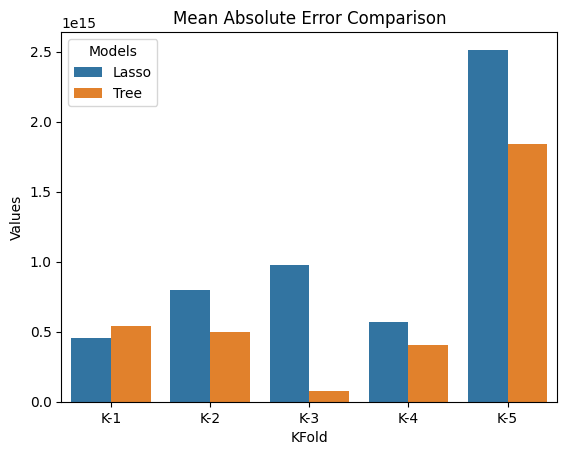

In [18]:
plot_chart(2, "Mean Absolute Error", "Mean Absolute Error Comparison")